In [1]:
import json
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster
import dask
import zarr
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs

from utils import smooth_inputs_dataset
from cm26_utils import load_and_combine_cm26

# set up gcs filesystem
# 👇 replace with your key 
with open( '/home/jovyan/KEYS/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
%config InlineBackend.figure_format='retina'

## Define the terms we will be looking at

Full output : $ \left \langle \overline{Q\left(T, U\right)} \right\rangle$

Large Scale Contribution : $\overline{Q\left(\left \langle T \right \rangle, \left \langle U \right \rangle \right)}$

Small Scale Contribution : $ \left \langle \overline{Q\left(T, U\right)} \right\rangle - \overline{Q\left(\left \langle T \right \rangle, \left \langle U \right \rangle \right)}$

$ \left \langle \overline{Q\left(T, U\right)} \right\rangle - \left \langle \overline{Q\left(T, \left \langle U \right \rangle \right)} \right\rangle$

$ \left \langle \overline{Q\left(T, U\right)} \right\rangle - \left \langle \overline{Q\left(\left \langle T \right \rangle, U\right)} \right\rangle$



In [2]:
def scale_separation(ds, filter_scale, mask):
    ds_filtered = smooth_inputs_dataset(
        ds,
        ['yt_ocean', 'xt_ocean'],
        filter_scale
    )
    diff_filtered = ds_filtered.sel(smoothing='smooth_full')-ds_filtered.sel(smoothing=['smooth_all', 'smooth_tracer', 'smooth_vel'])
    diff_unfiltered = ds_filtered.sel(smoothing='smooth_full')-ds.sel(smoothing=['smooth_all', 'smooth_tracer', 'smooth_vel'])
    
    # assigne scale datasets
    ds_full=ds_filtered.sel(smoothing='smooth_full')
    
    ds_large_scale = ds_filtered.sel(smoothing='smooth_all')
    
    ds_small_scale = xr.concat(
        [
            diff_unfiltered.sel(smoothing='smooth_all'), # the main result,
            diff_filtered.sel(smoothing=['smooth_tracer', 'smooth_vel']), # The mechanism 'hints'
        ],
        dim='smoothing'
    )
    
    # mask the outputs
    ds_full = ds_full.where(mask)
    ds_large_scale = ds_large_scale.where(mask)
    ds_small_scale = ds_small_scale.where(mask)
    
    return ds_full, ds_large_scale, ds_small_scale

In [3]:
def subsample(da, subsample):
    return da.isel(xt_ocean=slice(0, None, subsample), yt_ocean=slice(0, None, subsample))

In [8]:
def load_results(mapper):
    ds_loaded = xr.open_dataset(
        mapper,
        engine='zarr',
        chunks={},
        consolidated=True,
    )
    return ds_loaded

# Ice Mask + Eroded Land

In [4]:
# # quick and dirty look
# from intake import open_catalog

# cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
# ds_mask  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()

# plt.figure()
# (np.abs(ds_mask['melt'])>0).astype(int).sum('time').plot(levels=10)
# # super restrictive
# # ice_mask = (np.abs(ds['melt'])>0).any('time')
# # mask areas that are on average more than 6 months ice covered
# ice_mask = ((np.abs(ds_mask['melt'])>0).sum('time')>120)
# plt.figure()
# ice_mask.plot()

# from skimage.morphology import erosion, disk 
# # make a bigger land mask
# land = np.isnan(ds_mask['melt'].isel(time=0)).load()
# land_eroded = xr.ones_like(land) * np.nan
# land_eroded.data = ~erosion(~land.data, footprint=disk(30))
# plt.figure()
# land_eroded.plot()

# mask_combined = np.logical_and(~ice_mask, ~land_eroded)
# plt.figure()
# mask_combined.plot()
# plt.title('Final ocean mask')

## Load processed results

In [5]:
smooth_path =  'ocean-transport-group/scale-aware-air-sea/preprocessed/CM26_smoothed_split_v2.zarr'
smooth_mapper = fs.get_mapper(smooth_path)
ds_smoothed = xr.open_dataset(smooth_mapper, engine='zarr', chunks={}, consolidated=True)
# extract the filter scale used (TODO: Check that it is the same for all variables?
filter_scale = ds_smoothed.slp_smoothed.attrs['filter_scale']
# ds_smoothed

In [6]:
# TODO: Remove old stores ones once new work (from all levels of processing)

In [7]:
fs.ls('ocean-transport-group/scale-aware-air-sea/results')

['ocean-transport-group/scale-aware-air-sea/results/cm26_combined_map.zarr',
 'ocean-transport-group/scale-aware-air-sea/results/cm26_flux_long_term_mean_v2.zarr',
 'ocean-transport-group/scale-aware-air-sea/results/cm26_flux_seasonal_mean_v2.zarr']

In [9]:
mask_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_combined_map.zarr')
mean_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_flux_long_term_mean_v2.zarr')
season_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_flux_seasonal_mean_v2.zarr')

mask_combined = load_results(mask_mapper)['ice_land_mask']
ds_results_mean = load_results(mean_mapper)
ds_results_season = load_results(season_mapper)

In [10]:
# import dask
# from distributed import LocalCluster, Client

# with dask.config.set({"distributed.scheduler.worker-saturation": "1.0"}):
#     client = Client(LocalCluster())
# client

from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()

options.worker_memory = 16 # 24 works fine for long term mean, but seasonal needs a bit more
# options.worker_cores = 8

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.adapt(4, 100)
client

[]


<Client: 'tls://10.0.176.2:8786' processes=0 threads=0, memory=0 B>

## Filter results and compute small scale contribution

In [11]:
ds_full_mean, ds_large_scale_mean, ds_small_scale_mean = scale_separation(ds_results_mean, filter_scale, mask_combined)
ds_full_season, ds_large_scale_season, ds_small_scale_season = scale_separation(ds_results_season, filter_scale, mask_combined)

In [12]:
# the full field
with ProgressBar():
    ds_full_mean = subsample(ds_full_mean, 3).persist()
    print(ds_full_mean.nbytes/1e9)
    ds_large_scale_mean = subsample(ds_large_scale_mean, 3).persist()
    print(ds_large_scale_mean.nbytes/1e9)
    ds_small_scale_mean = subsample(ds_small_scale_mean, 3).persist()
    print(ds_small_scale_mean.nbytes/1e9)

0.11665702
0.11665702
0.332657124


In [13]:
# the seasonal field
with ProgressBar():
    ds_full_season = subsample(ds_full_season, 3).persist()
    print(ds_full_season.nbytes/1e9)
    ds_large_scale_season = subsample(ds_large_scale_season, 3).persist()
    ds_small_scale_season = subsample(ds_small_scale_season, 3).persist()
    print(ds_small_scale_season.nbytes/1e9)

0.267857052
0.786257156


In [14]:
#TODO: Once settled on some final version, save these out. They take annoyingly long to load.

In [14]:
# common plotting stuff
projection = ccrs.Robinson(195)

# Figures

## Figure 2: Long term contributions of small scales

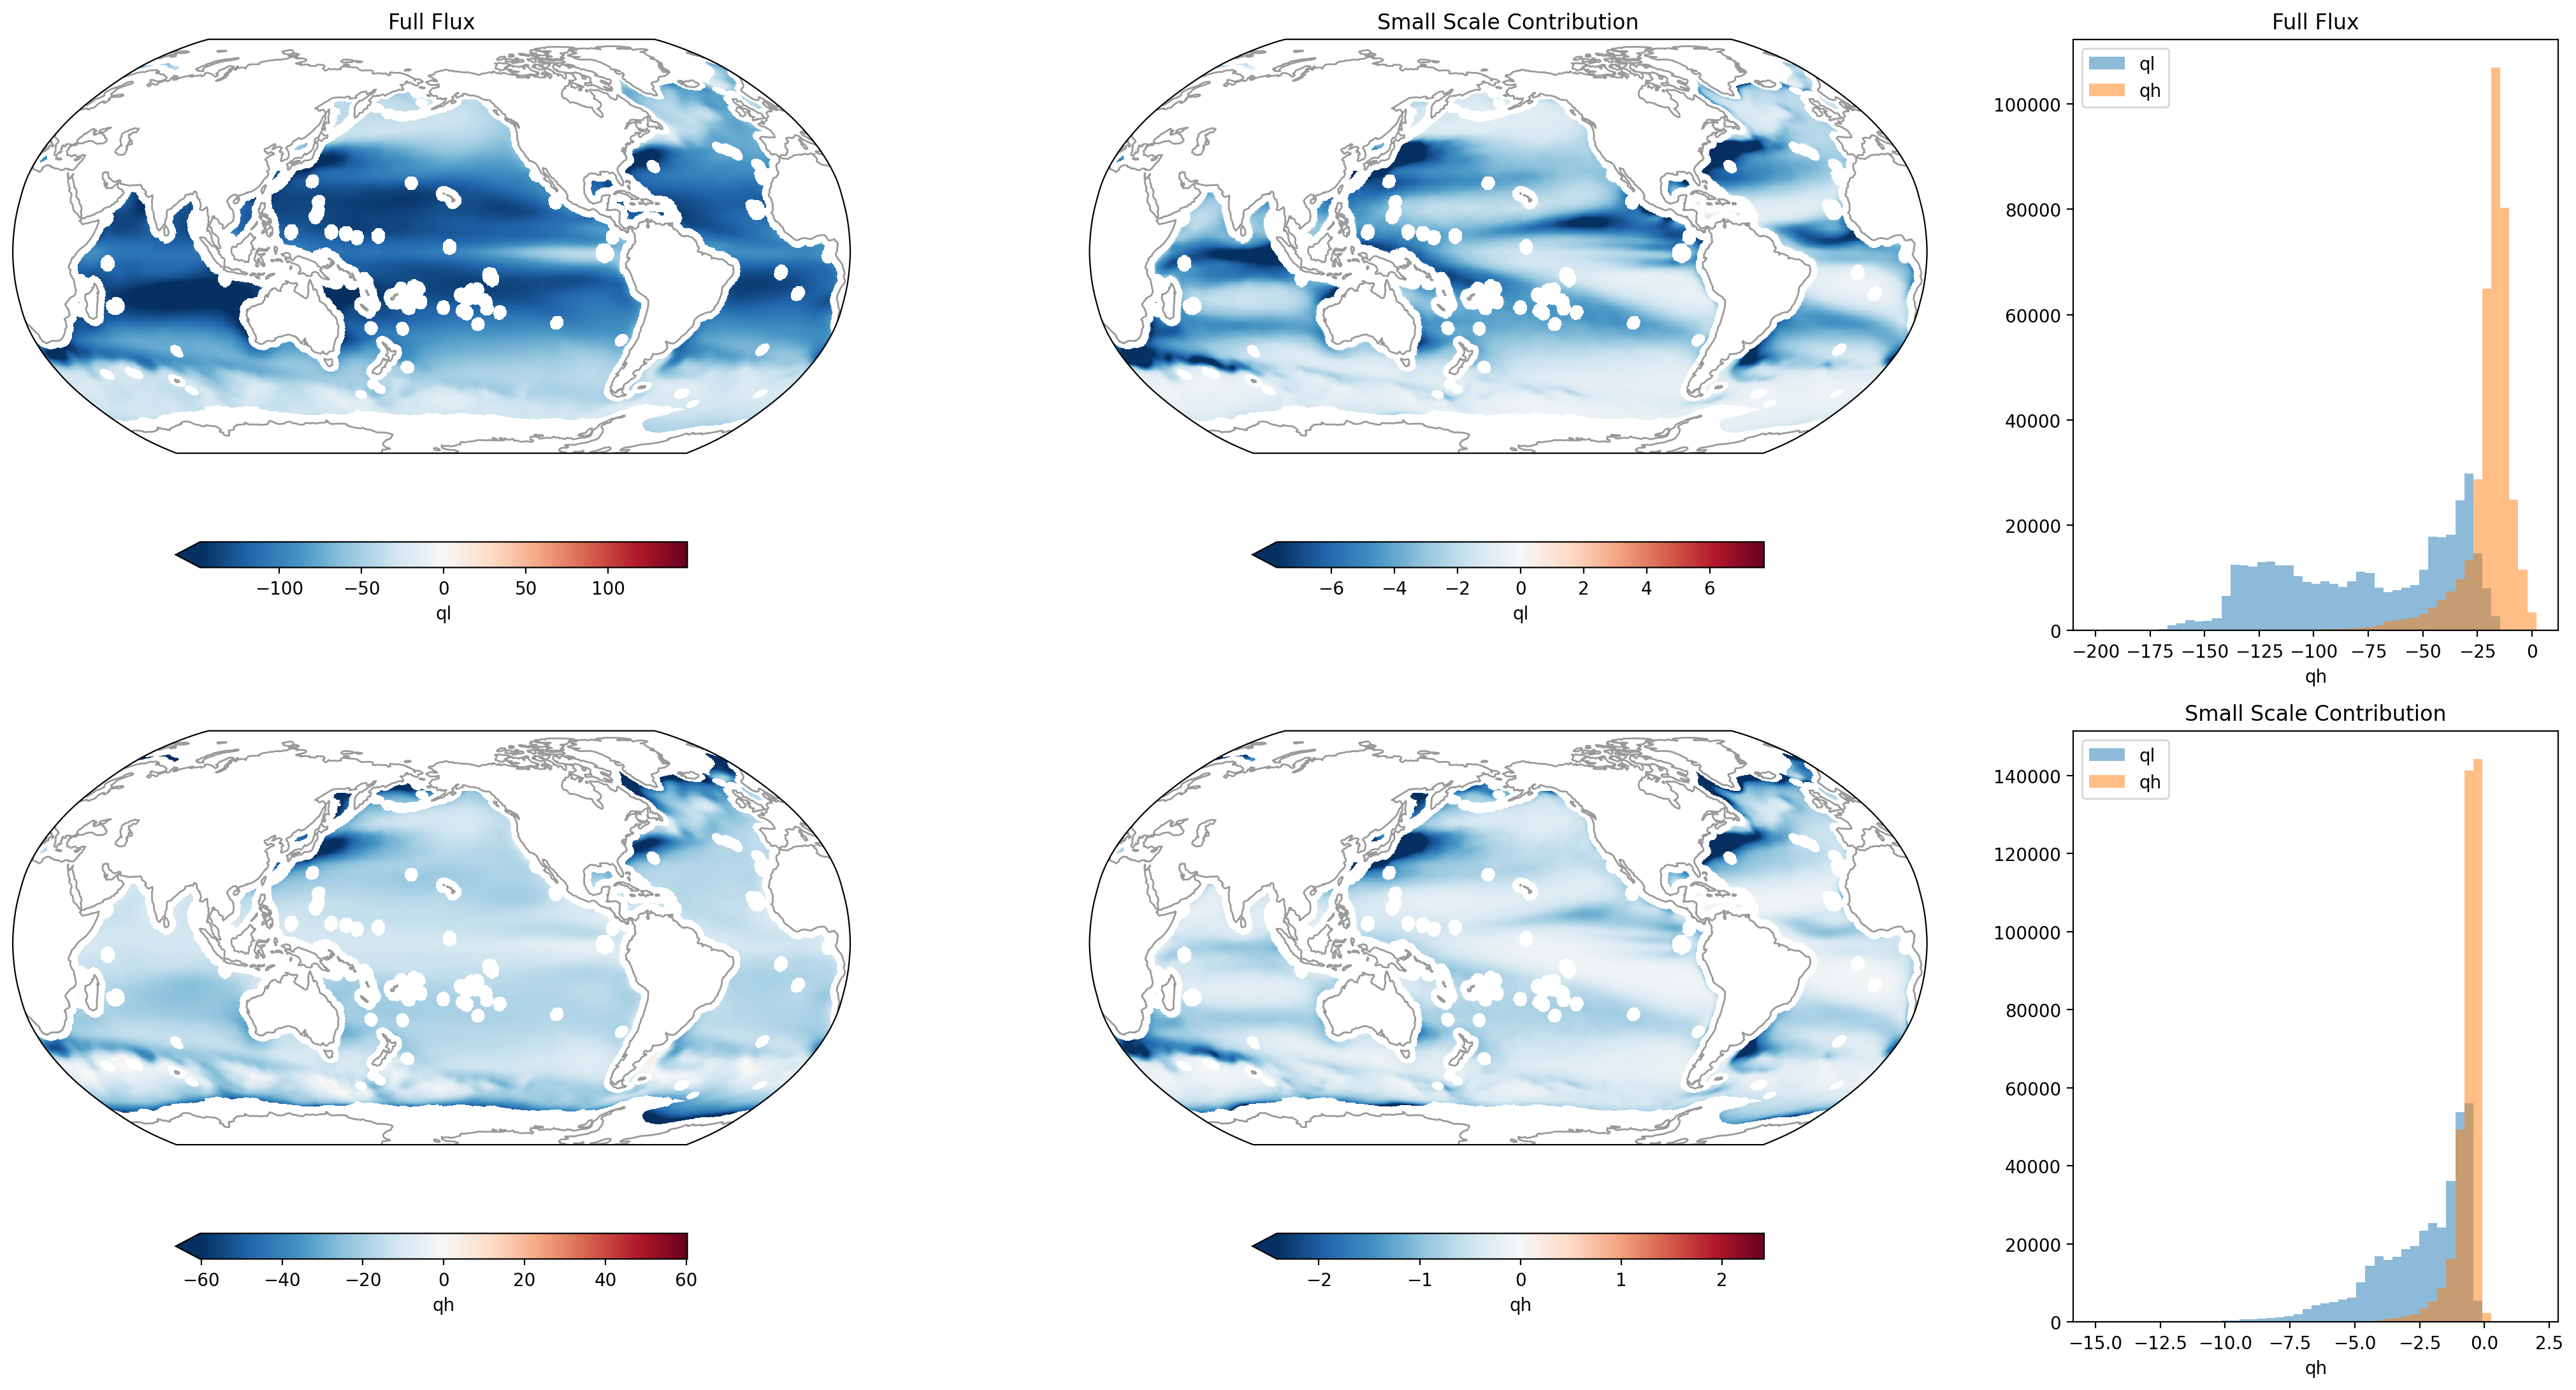

In [15]:
plot_kwargs = dict(transform=ccrs.PlateCarree(),cbar_kwargs = {'location':'bottom', 'shrink':0.5}, center=0)


fig = plt.figure(figsize = [7*3, 11])
gs = fig.add_gridspec(2, 5)


axarr = np.array(
    [
        [
            fig.add_subplot(gs[0, 0:2], projection=projection),
            fig.add_subplot(gs[0, 2:4], projection=projection),
            fig.add_subplot(gs[0, 4],),
        ],
        [
            fig.add_subplot(gs[1, 0:2], projection=projection),
            fig.add_subplot(gs[1, 2:4], projection=projection),   
            fig.add_subplot(gs[1, 4]),
        ]
    ])
        
for vi, var in enumerate(['ql', 'qh']):
    axarr_var = axarr[vi,:]
    
    da_plot_full = ds_full_mean[var].mean('algo')
    da_plot_small= ds_small_scale_mean[var].sel(smoothing='smooth_all').mean('algo')

    da_plot_full.plot(ax=axarr_var[0],robust=True, **plot_kwargs)
    
    da_plot_small.plot(ax=axarr_var[1], robust=True, **plot_kwargs)
    
    da_plot_full.plot.hist(bins=np.linspace(-200, 2, 50), ax=axarr[0,2], label=var, alpha=0.5)
    
    da_plot_small.plot.hist(bins=np.linspace(-15, 2, 50), ax=axarr[1,2], label=var, alpha=0.5)
    
# clean up titles
axarr[0,0].set_title('Full Flux')
axarr[0,1].set_title('Small Scale Contribution')
for ax in axarr[1,:-1].flat:
    ax.set_title('')
for ax in axarr[:,0:-1].flat:
    ax.coastlines(color='0.6')

axarr[0,2].set_title('Full Flux')
axarr[1,2].set_title('Small Scale Contribution')
axarr[0,2].legend()
axarr[1,2].legend()
fig.tight_layout()
#TODO: Make the maps a bit bigger (might have to split up the grid more finely for that

## Figure 3: Mechanisms

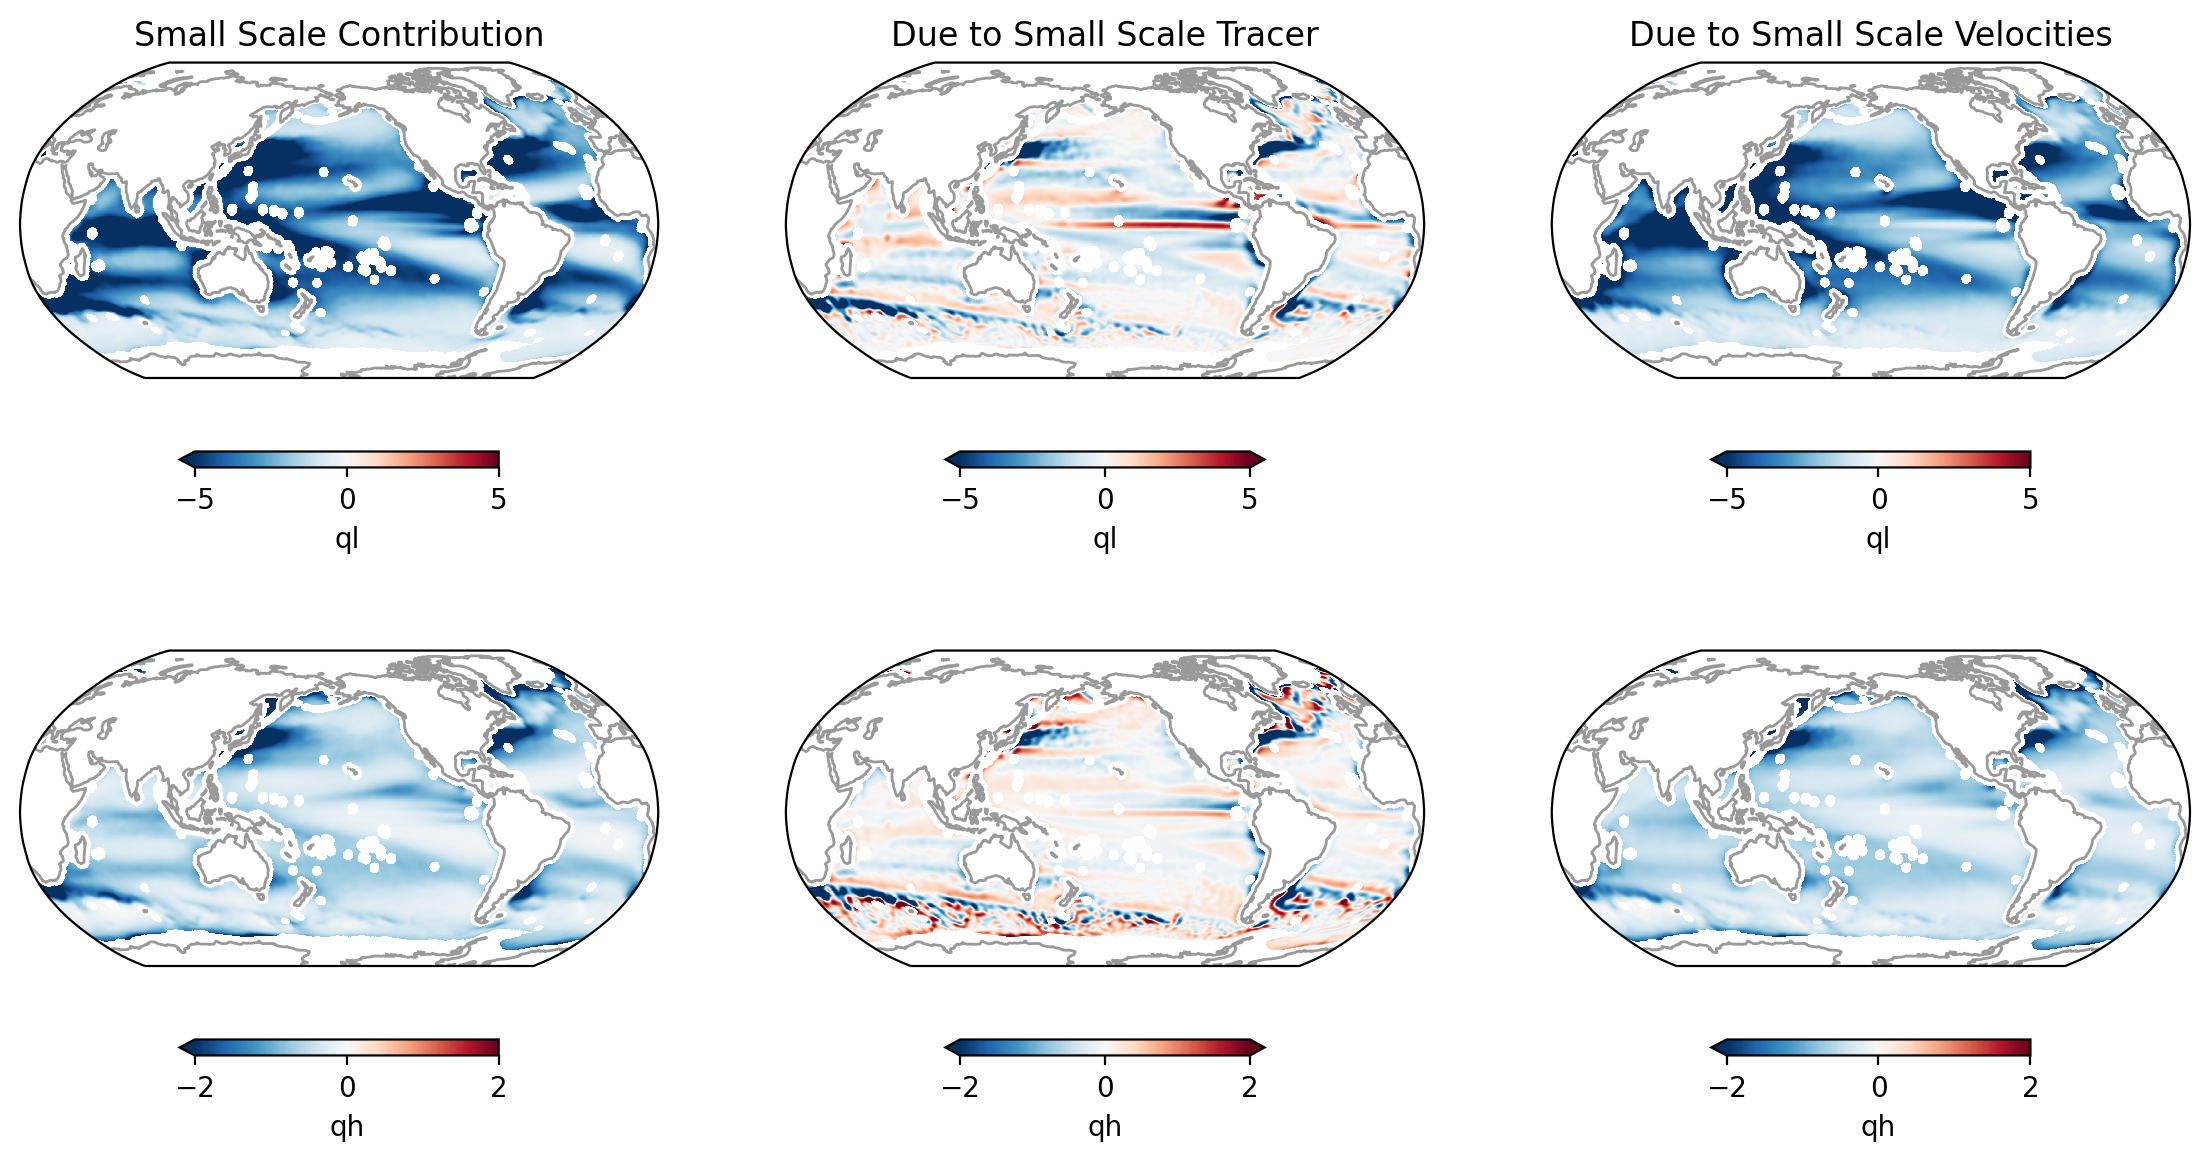

In [16]:
plot_kwargs = dict(transform=ccrs.PlateCarree(),cbar_kwargs = {'location':'bottom', 'shrink':0.5}, center=0)

# ds_plot = subsample(ds_small_scale_mean.mean('algo'), 5)
ds_plot = ds_small_scale_mean.sel(algo='ecmwf')

fig, axarr = plt.subplots(ncols=3, nrows=2, subplot_kw={'projection':projection}, figsize=[14, 7])
for vi, (var, vmax) in enumerate([('ql', 5), ('qh', 2)]):
    for si, smoothing in enumerate(['smooth_all', 'smooth_tracer', 'smooth_vel']):
        ax = axarr[vi,si]
        da_plot = ds_plot[var].sel(smoothing=smoothing).plot(ax=ax, vmax=vmax, **plot_kwargs)
    
# # clean up titles
axarr[0,0].set_title('Small Scale Contribution')
axarr[0,1].set_title('Due to Small Scale Tracer')
axarr[0,2].set_title('Due to Small Scale Velocities')
for ax in axarr[1,:].flat:
    ax.set_title('')
for ax in axarr.flat:
    ax.coastlines(color='0.6')

## Figure ? : Seasonal Signal
Lets see if this is at all interesting...

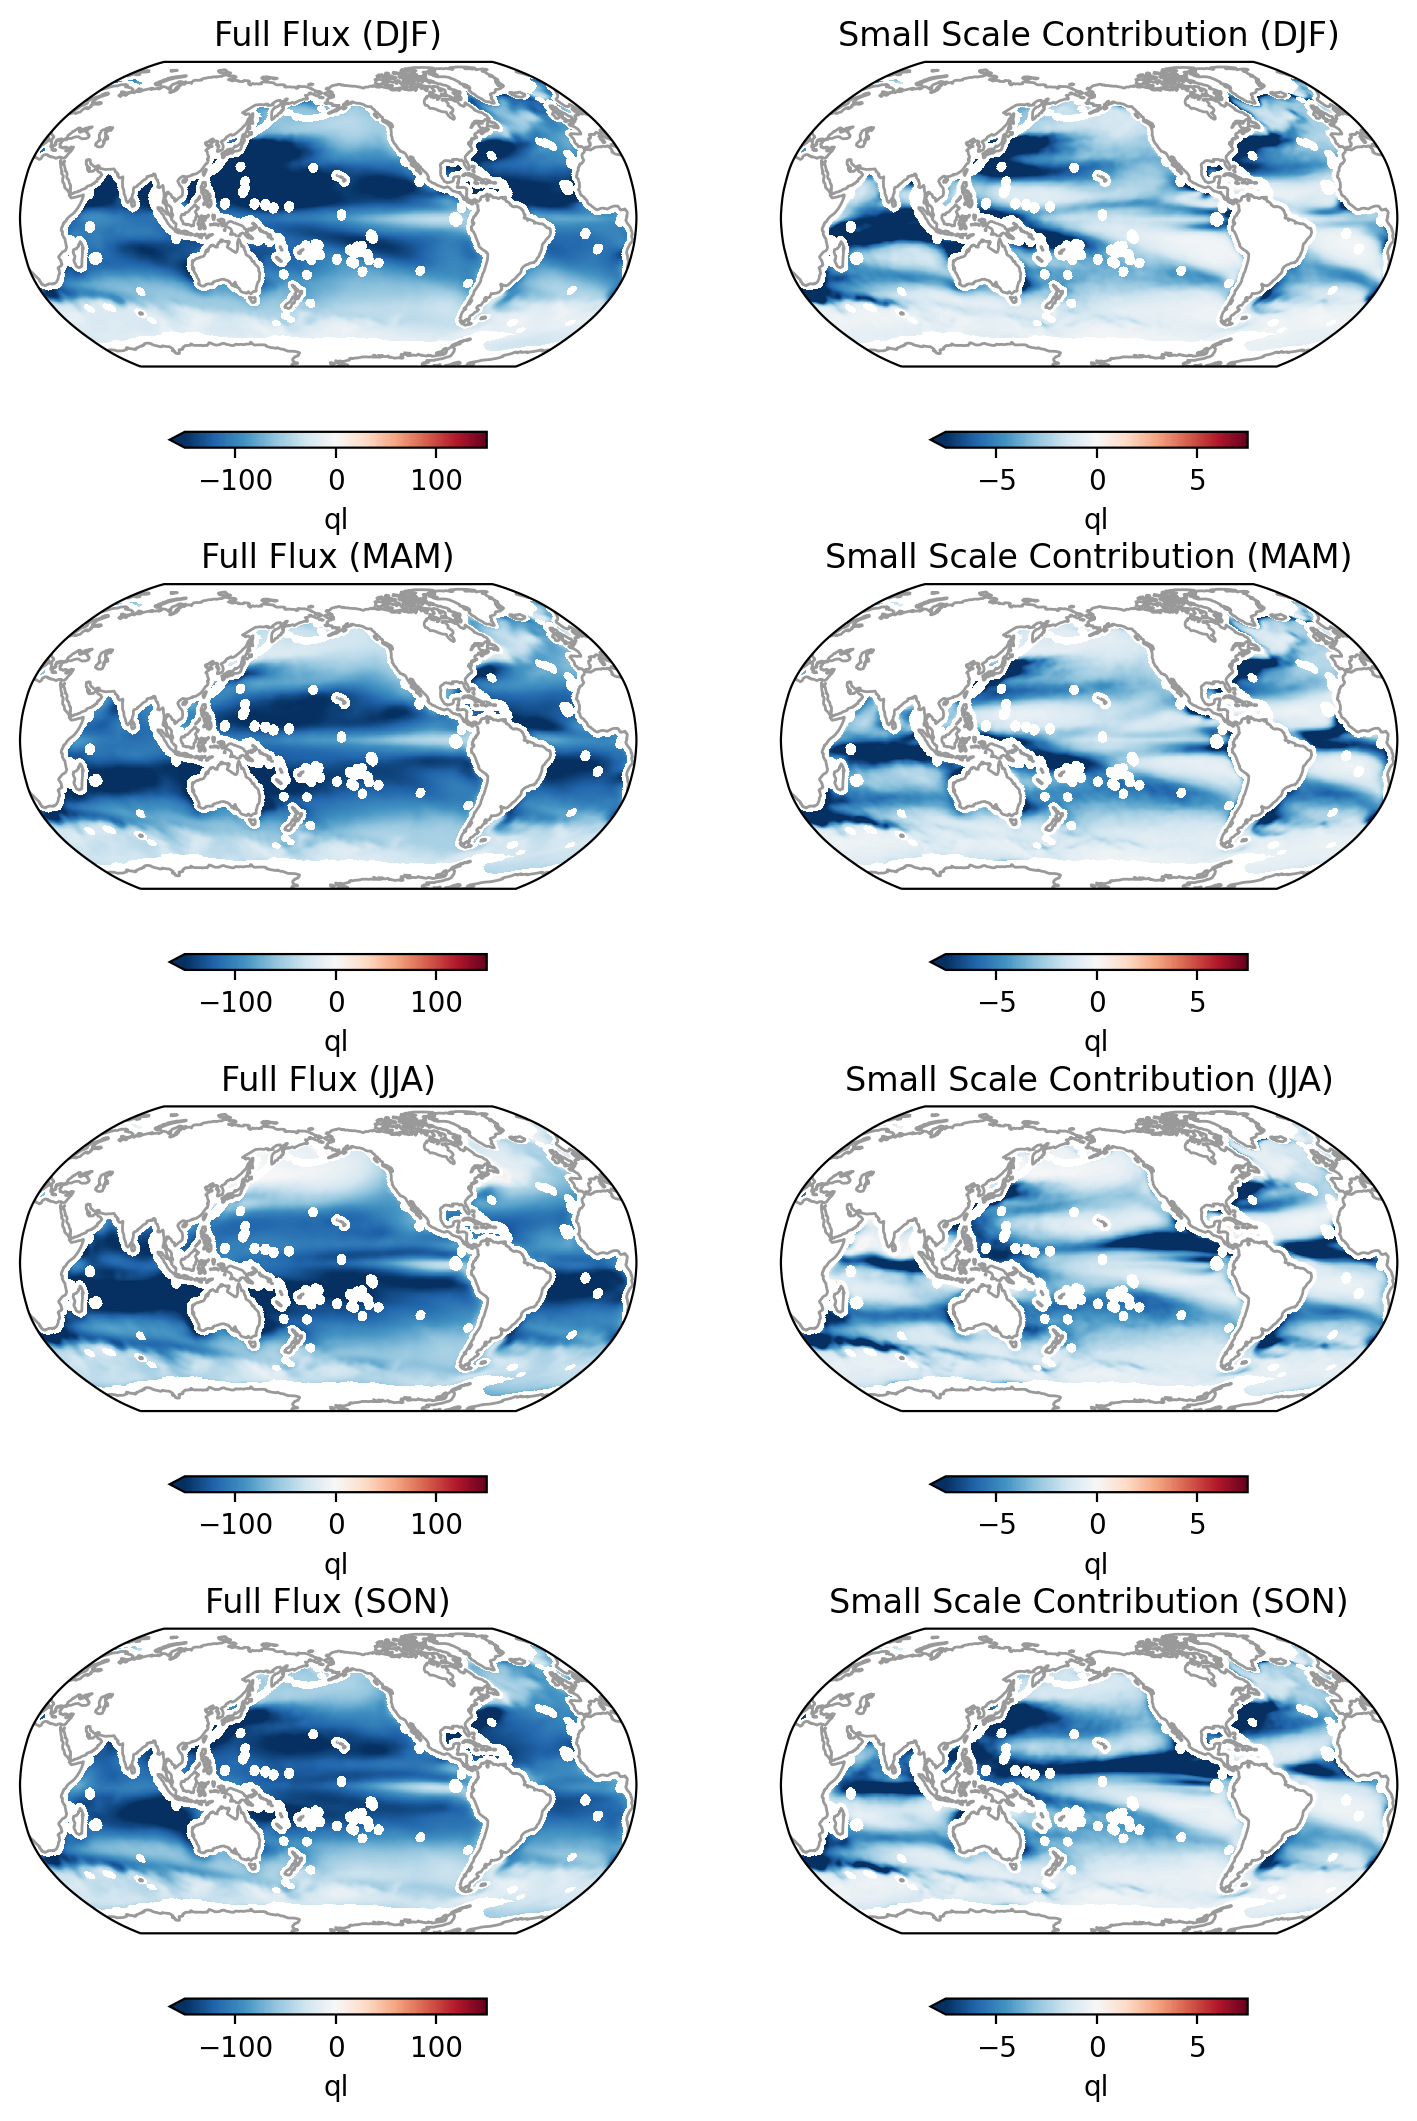

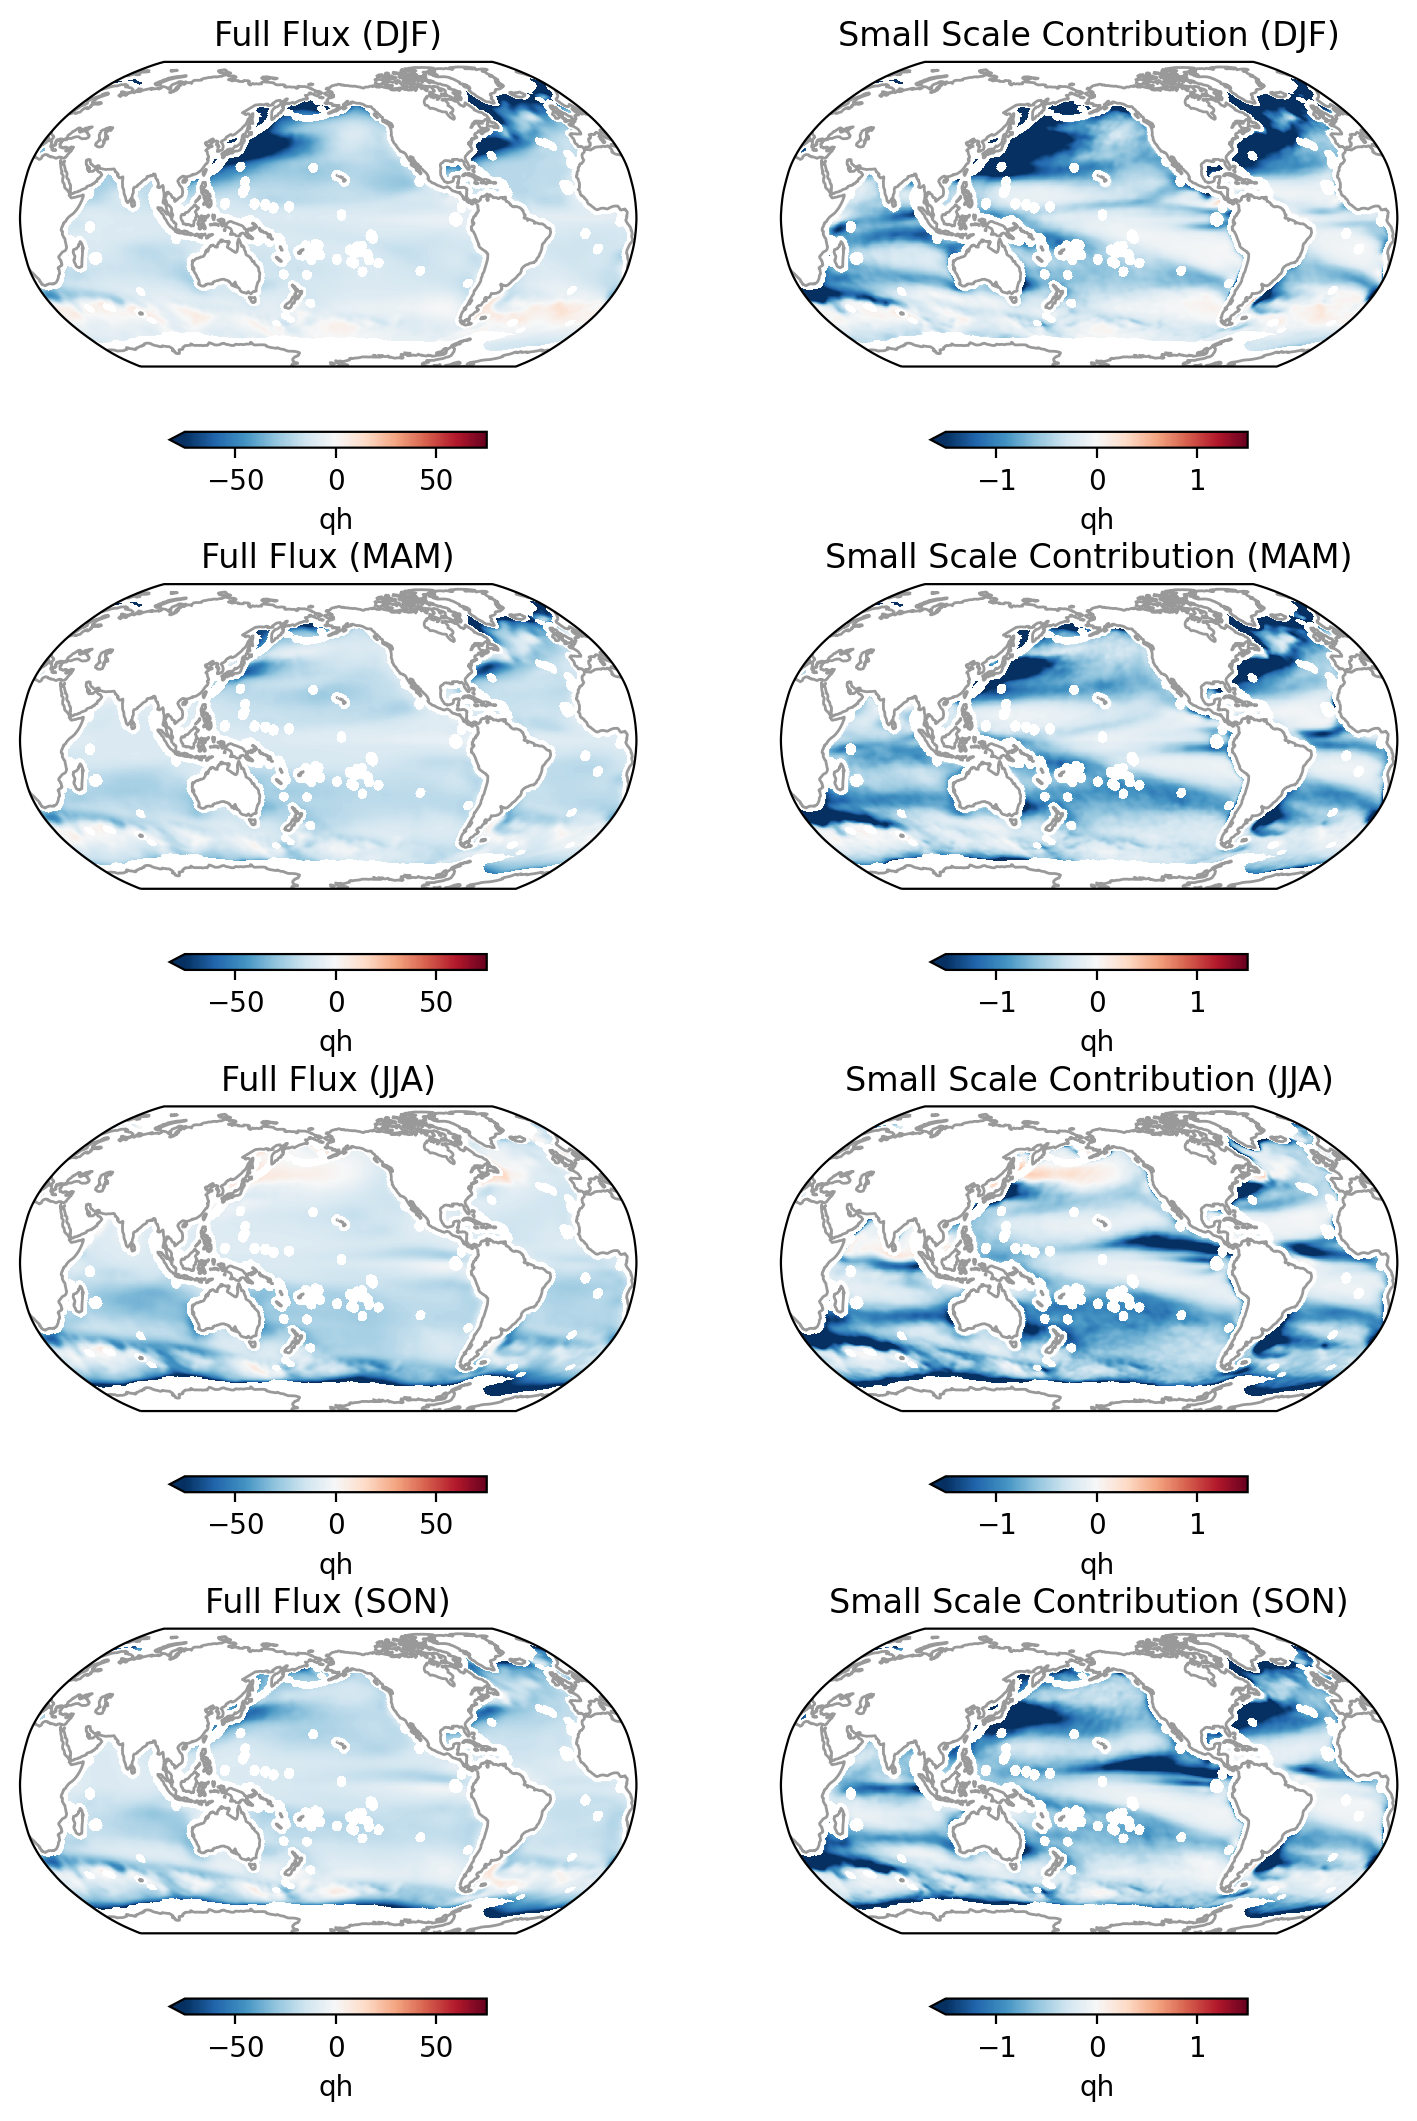

2022-11-03 15:53:42,731 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [28]:
plot_kwargs = dict(transform=ccrs.PlateCarree(),cbar_kwargs = {'location':'bottom', 'shrink':0.5}, center=0)

# ds_plot = subsample(ds_small_scale_mean.mean('algo'), 5)
ds_plot_full = ds_full_season.sel(algo='ecmwf')
ds_plot_small = ds_small_scale_season.sel(algo='ecmwf', smoothing='smooth_all')

for vi, (var, vmax_full, vmax_small) in enumerate([('ql', 150, 7.5), ('qh', 75, 1.5)]):
    fig, axarr = plt.subplots(ncols=2, nrows=4, subplot_kw={'projection':projection}, figsize=[9, 13])
    for si, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        

        ax = axarr[si,0]
        ds_plot_full[var].sel(season=season).plot(ax=ax, vmax=vmax_full, **plot_kwargs)
        ax.set_title(f"Full Flux ({season})")
        ax = axarr[si,1]
        ds_plot_small[var].sel(season=season).plot(ax=ax, vmax=vmax_small, **plot_kwargs)
        ax.set_title(f"Small Scale Contribution ({season})")

        # print(si)
        # axarr[si,0].text(0.5, 0.5, 'latitude', va='bottom', ha='center',
        # rotation='vertical', rotation_mode='anchor',
        # transform=ax.transAxes)
    
    # # clean up titles
    # axarr[0,1].set_title('Small Scale Contribution')
    # axarr[0,0].set_title('Full Flux')
    # for ax in axarr[1:,:].flat:
    #     ax.set_title('')
    for ax in axarr.flat:
        ax.coastlines(color='0.6')

TypeError: 'Future' object is not subscriptable

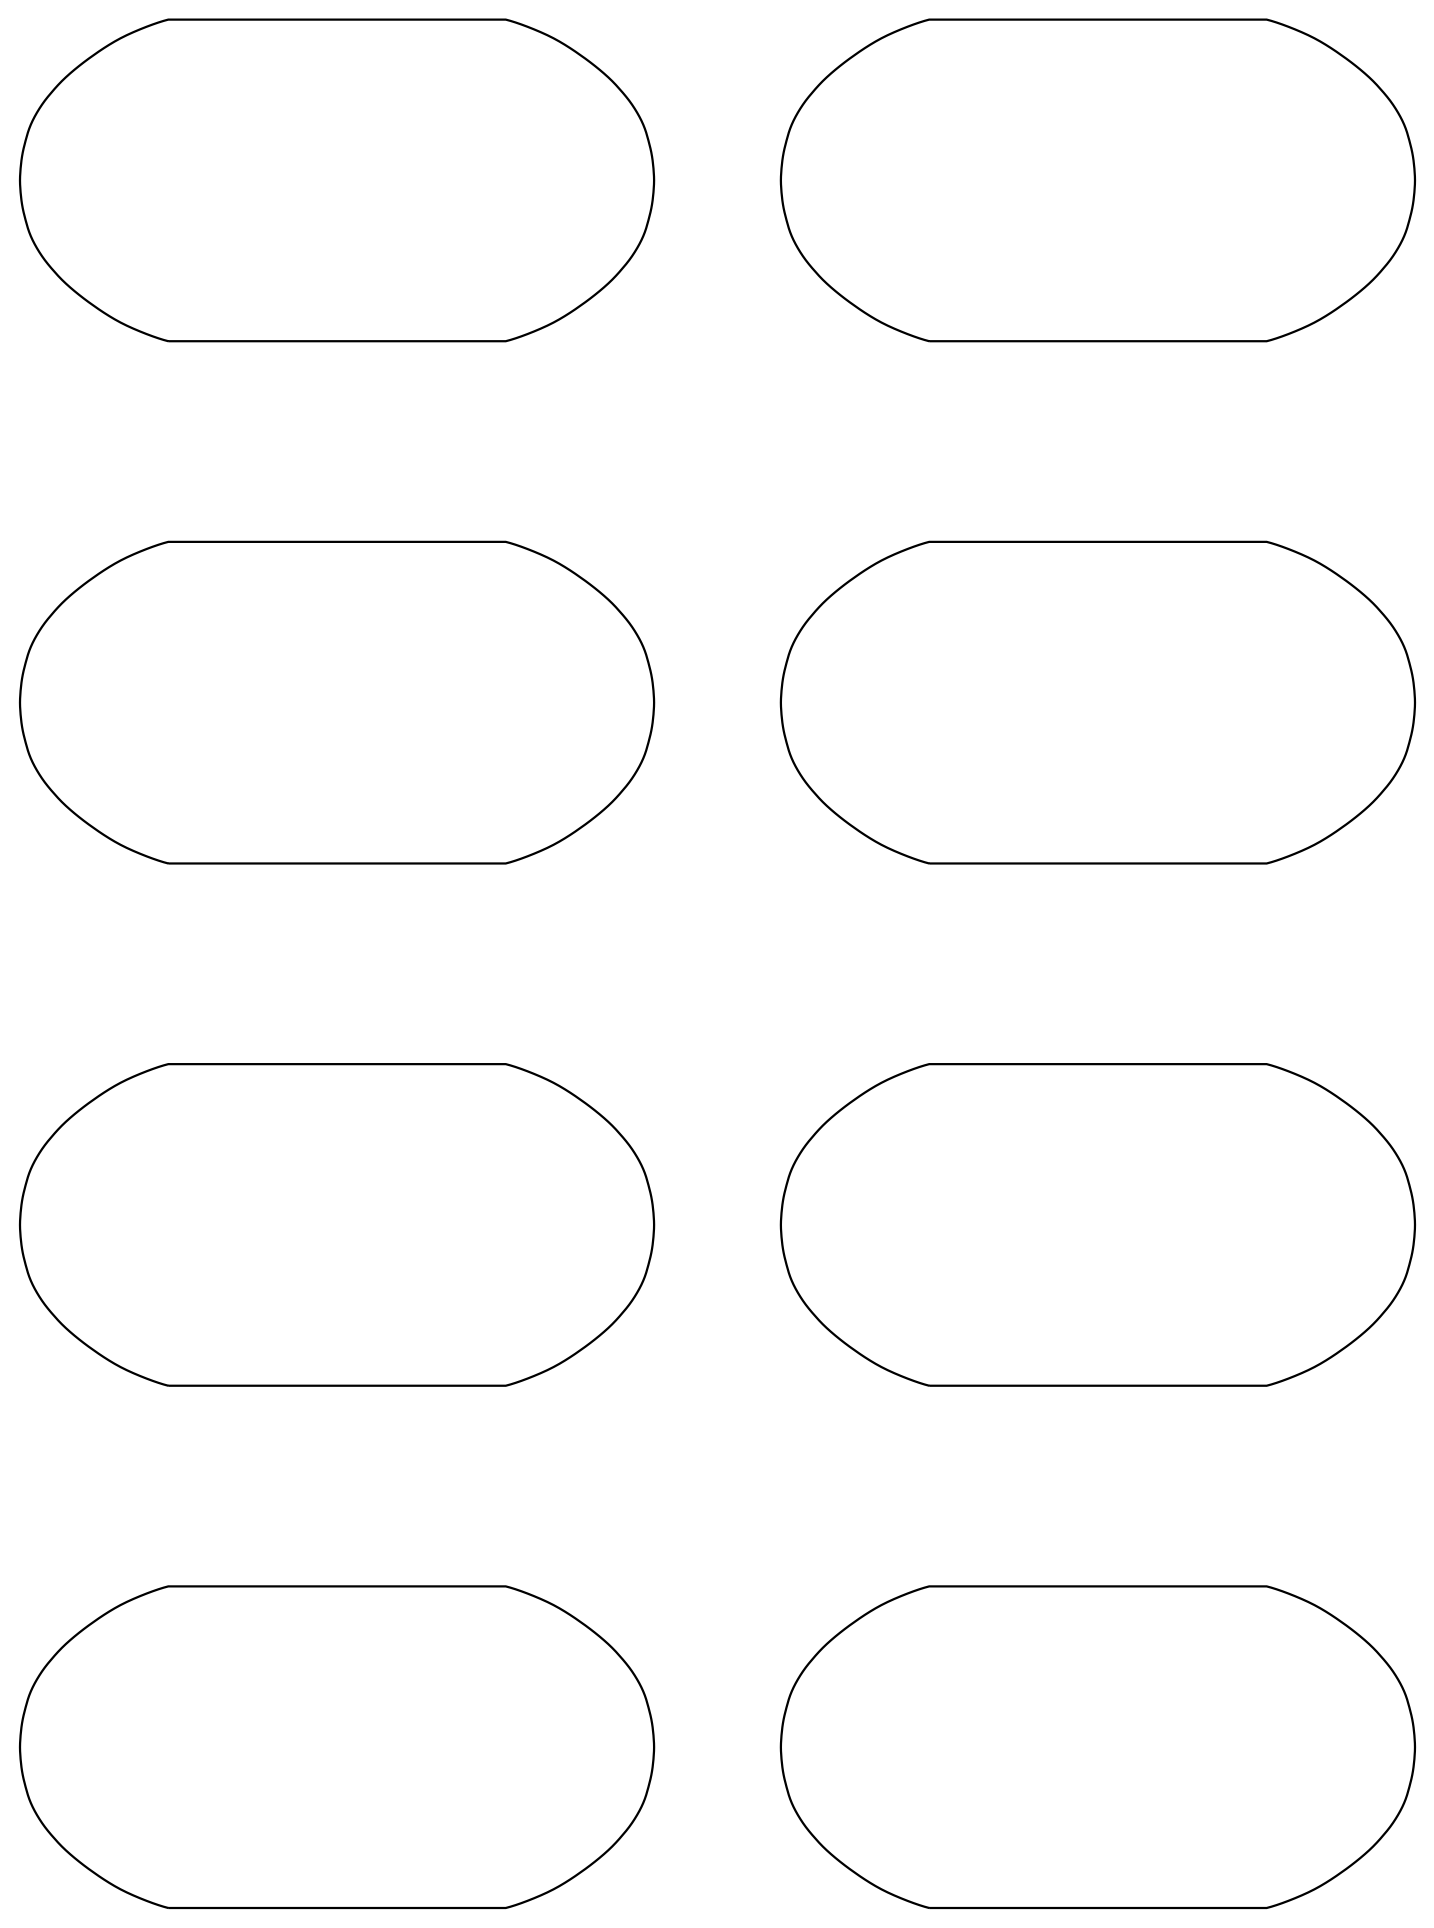

In [29]:
plot_kwargs = dict(transform=ccrs.PlateCarree(),cbar_kwargs = {'location':'bottom', 'shrink':0.5}, center=0)

# ds_plot = subsample(ds_small_scale_mean.mean('algo'), 5)
ds_plot_full = ds_full_season.sel(algo='ecmwf')
ds_plot_small = ds_small_scale_season.sel(algo='ecmwf', smoothing='smooth_all')

for vi, (var, vmax_full, vmax_small) in enumerate([('ql', 150, 7.5), ('qh', 40, 1.5)]):
    fig, axarr = plt.subplots(ncols=2, nrows=4, subplot_kw={'projection':projection}, figsize=[9, 13])
    for si, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        

        ax = axarr[si,0]
        ds_plot_full[var].sel(season=season).plot(ax=ax, vmax=vmax_full, **plot_kwargs)
        ax.set_title(f"Full Flux ({season})")
        ax = axarr[si,1]
        ds_plot_small[var].sel(season=season).plot(ax=ax, vmax=vmax_small, **plot_kwargs)
        ax.set_title(f"Small Scale Contribution ({season})")

        # print(si)
        # axarr[si,0].text(0.5, 0.5, 'latitude', va='bottom', ha='center',
        # rotation='vertical', rotation_mode='anchor',
        # transform=ax.transAxes)
    
    # # clean up titles
    # axarr[0,1].set_title('Small Scale Contribution')
    # axarr[0,0].set_title('Full Flux')
    # for ax in axarr[1:,:].flat:
    #     ax.set_title('')
    for ax in axarr.flat:
        ax.coastlines(color='0.6')

In [17]:
ds_small_scale_season#['qh'].sel(algo='ecmwf', smoothing='smooth_all').plot(col='season', col_wrap=2, robust=True)

<xarray.Dataset>
Dimensions:    (algo: 5, season: 4, yt_ocean: 900, xt_ocean: 1200, smoothing: 3)
Coordinates:
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * smoothing  (smoothing) <U13 'smooth_all' 'smooth_tracer' 'smooth_vel'
  * xt_ocean   (xt_ocean) float64 -279.9 -279.6 -279.3 ... 79.15 79.45 79.75
  * yt_ocean   (yt_ocean) float64 -81.11 -80.98 -80.86 ... 89.64 89.77 89.89
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(113, 150), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(113, 150), meta=np.ndarray>
    time       object ...
Data variables:
    evap       (algo, season, yt_ocean, xt_ocean, smoothing) float32 dask.array<chunksize=(1, 4, 900, 1200, 1), meta=np.ndarray>
    qh         (algo, season, yt_ocean, xt_ocean, smoothing) float32 dask.array<chunksize=(1, 4, 900, 1200, 1), meta=np.ndarray>
    ql         (algo, season, yt_ocean, xt_ocean, smoothing) float32 dask.array<chunksize=(1, 4, 900, 1200, 1), meta=np.ndarray>

In [ ]:
ds_full_season['qh'].sel(algo='ecmwf').plot(col='season', col_wrap=2, robust=True)

# Appendix Plots

## A1: Difference of results across algos

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


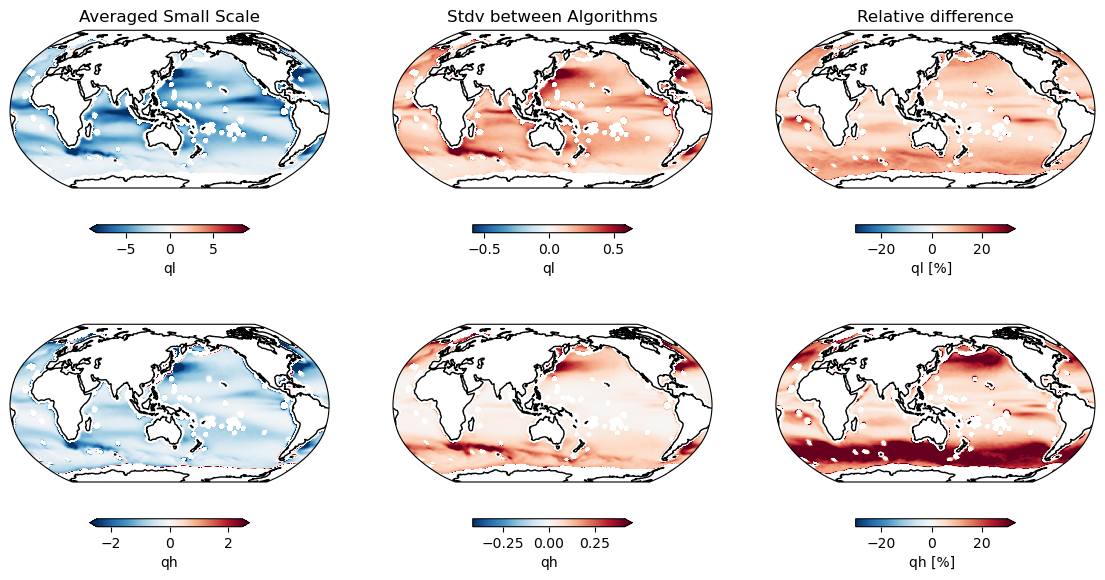

In [78]:
ds_plot = subsample(ds_small_scale.sel(smoothing='smooth_all'), 5)
plot_kwargs = dict(transform=ccrs.PlateCarree(),cbar_kwargs = {'location':'bottom', 'shrink':0.5}, center=0)

fig, axarr = plt.subplots(ncols=3, nrows=2, subplot_kw={'projection':projection}, figsize=[14, 7])
for vi, var in enumerate(['ql', 'qh']):
    da_plot = ds_plot[var]
    axarr_var = axarr[vi,:]
    mean = da_plot.mean('algo')
    std = da_plot.std('algo')
    relative = std/abs(mean)*100
    relative.attrs['name'] = 'Relative Error'
    relative.attrs['units'] = '%'
    
    # mean
    mean.plot(ax=axarr_var[0], robust=True, **plot_kwargs)
    # std
    std.plot(ax=axarr_var[1], robust=True, **plot_kwargs)
    # relative
    relative.plot(ax=axarr_var[2], vmax=30, **plot_kwargs)
    
# clean up titles
axarr[0,0].set_title('Averaged Small Scale')
axarr[0,1].set_title('Stdv between Algorithms')
axarr[0,2].set_title('Relative difference')
for ax in axarr[1,:].flat:
    ax.set_title('')
for ax in axarr.flat:
    ax.coastlines()

## Velocity Histograms (Appendix Plot)

In [10]:
from xhistogram.xarray import histogram 

In [11]:
# import dask
# from distributed import LocalCluster, Client

# with dask.config.set({"distributed.scheduler.worker-saturation": "1.0"}):
#     client = Client(LocalCluster())
# client

2022-11-02 00:29:45,301 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-lc5wj4dm', purging
2022-11-02 00:29:45,302 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-m6vpnbb1', purging


<Client: 'tcp://127.0.0.1:37729' processes=4 threads=16, memory=58.87 GiB>

In [ ]:
ds_original = load_and_combine_cm26(fs, inline_array=True)
# ds_original

In [12]:
u_abs = (ds_original.u_relative**2 + ds_original.v_relative**2)**0.5
u_abs.name = 'velocity_magnitude'
u_abs = u_abs.isel(time=slice(0,700))

# get aroudnt this annoying bug (https://github.com/xgcm/xhistogram/issues/16)
# u_abs = u_abs.chunk({'time':3}) #Doesnt work
# the only way to do this, is to not compute the hist over time and then sum it...
hist = histogram(u_abs, bins=[np.arange(0, 30,0.1)], dim=['xt_ocean','yt_ocean'])
hist = hist.load()#.isel(time=73).plot.hist()

In [13]:
u_abs_smoothed = (ds_smoothed.u_relative_smoothed**2 + ds_smoothed.v_relative_smoothed**2)**0.5
u_abs_smoothed.name = 'velocity_magnitude'
u_abs_smoothed = u_abs_smoothed.isel(time=slice(0,700))


hist_smoothed = histogram(u_abs_smoothed, bins=[np.arange(0, 30,0.1)], dim=['xt_ocean','yt_ocean'])
hist_smoothed = hist_smoothed.load()#.isel(time=73).plot.hist()

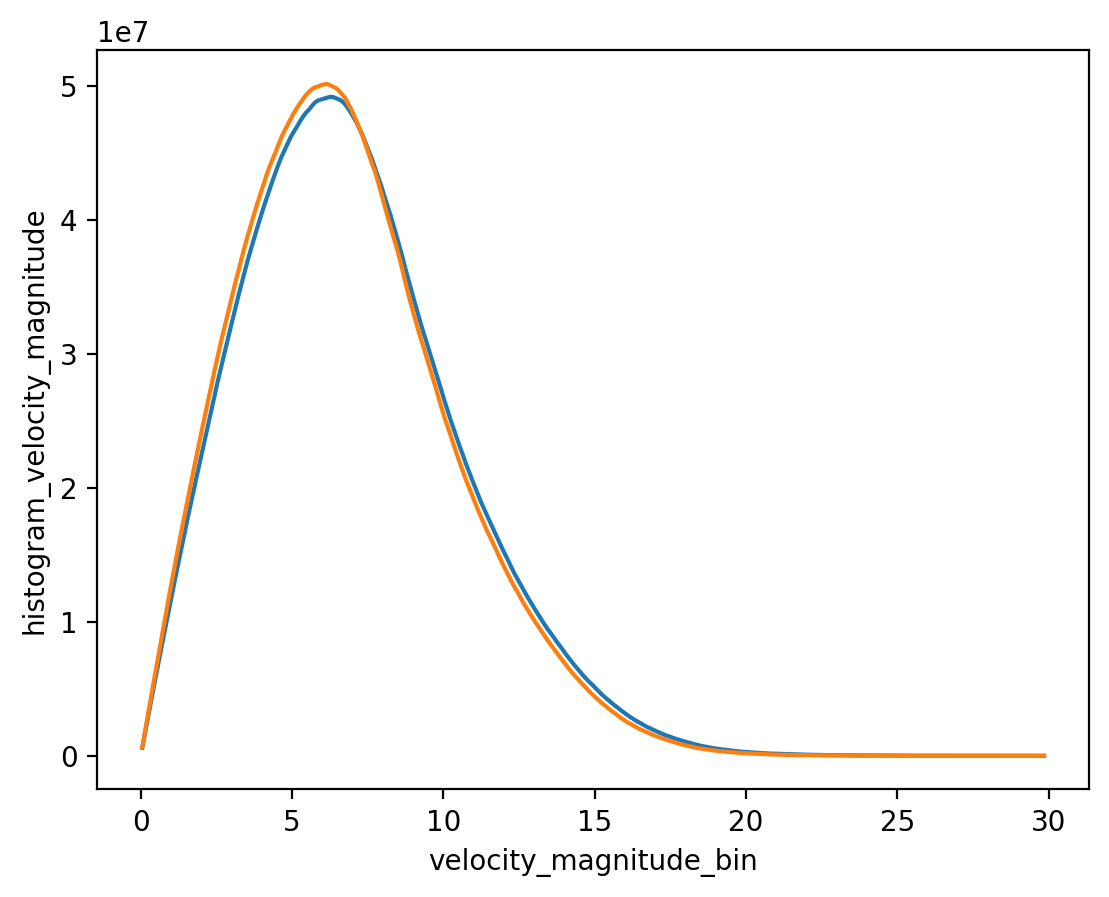

In [14]:
hist.sum('time').plot(label='unsmoothed')
hist_smoothed.sum('time').plot(label='smoothed')